Downloading and installing necessary packages

In [ ]:
!pip install damagescanner==0.9b15
!pip install rasterstats
!pip install rioxarray

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
# Loading necessary data packages
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import re
import rioxarray as rxr
from rasterstats import zonal_stats
from shapely.geometry import Point
from shapely.geometry import LineString

# Importing necessary libraries
# sys.path.append('') #'your-path-to/osm-flex/src'
import damagescanner.download as download
from damagescanner.core import DamageScanner
from damagescanner.osm import read_osm_data

1. Using the OSM Flex package to download the Road Network for Spain

In [ ]:
country_iso3 = 'ESP'

In [ ]:
infrastructure_path = download.get_country_geofabrik(country_iso3)

In [ ]:
gdf_esp_road = gpd.read_file(infrastructure_path, layer="lines")
gdf_esp_road = gdf_esp_road[gdf_esp_road["highway"].values != None]

In [ ]:
# Function to extract tags from the 'other_tags' field
def extract_tag(tag_string, key):
    if pd.isna(tag_string):
        return None
    # Use regex to extract the specific tag value
    pattern = f'"{key}"=>"([^"]*)"'
    match = re.search(pattern, str(tag_string))
    return match.group(1) if match else None

# Extract desired tags from other_tags column
print("Extracting maxspeed, lanes, and surface from other_tags column...")
gdf_esp_road['maxspeed'] = gdf_esp_road['other_tags'].apply(lambda x: extract_tag(x, 'maxspeed'))
gdf_esp_road['lanes'] = gdf_esp_road['other_tags'].apply(lambda x: extract_tag(x, 'lanes'))
gdf_esp_road['surface'] = gdf_esp_road['other_tags'].apply(lambda x: extract_tag(x, 'surface'))

# Select and rename the desired columns
columns_to_keep = ['osm_id', 'name', 'highway', 'maxspeed', 'lanes', 'surface', 'geometry']
Spain_Roads = gdf_esp_road[columns_to_keep].copy()

# Display basic information
print(f"\nRoad network processed successfully.")
print(f"Total road segments: {len(Spain_Roads)}")
print(f"Columns available: {', '.join(Spain_Roads.columns)}")

# Check number of roads with each tag type
print(f"\nRoads with maxspeed data: {Spain_Roads['maxspeed'].notna().sum()} of {len(Spain_Roads)}")
print(f"Roads with lanes data: {Spain_Roads['lanes'].notna().sum()} of {len(Spain_Roads)}")
print(f"Roads with surface data: {Spain_Roads['surface'].notna().sum()} of {len(Spain_Roads)}")

# Display a sample of the first few rows
print("\nSample of the processed data:")
print(Spain_Roads.head())

Extracting maxspeed, lanes, and surface from other_tags column...

Road network processed successfully.
Total road segments: 5328909
Columns available: osm_id, name, highway, maxspeed, lanes, surface, geometry

Roads with maxspeed data: 436148 of 5328909
Roads with lanes data: 548996 of 5328909
Roads with surface data: 1401158 of 5328909

Sample of the processed data:
    osm_id                 name    highway maxspeed lanes  surface  \
0   407780       Oviedo-Porceyo  secondary     None     1     None   
1  2497138             Pit Lane    raceway     None  None  asphalt   
2  2497139      Curva Sito Pons    raceway     None  None  asphalt   
3  2497152  Curva Alex Criville    raceway     None  None  asphalt   
4  3318645                 None    primary       40     1  asphalt   

                                            geometry  
0  LINESTRING (-5.78146 43.44459, -5.78127 43.444...  
1  LINESTRING (-6.03241 36.70754, -6.03222 36.707...  
2  LINESTRING (-6.02809 36.70913, -6.02795 

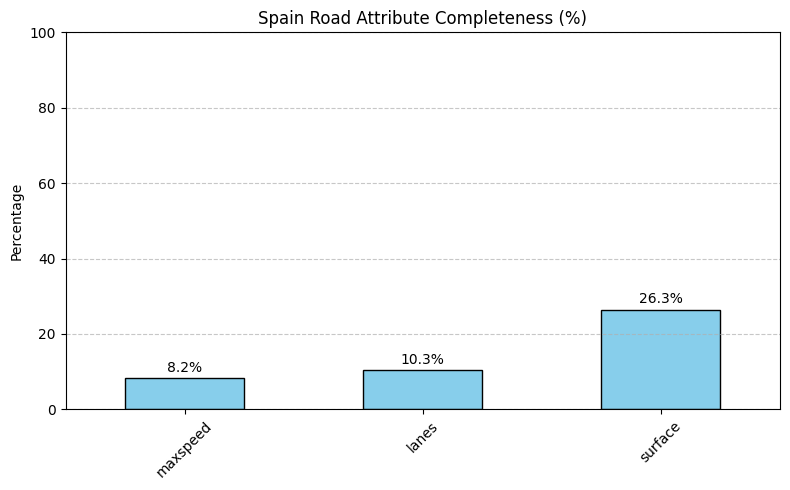

In [ ]:
# Assign DataFrame for easier handling
df_Spain = Spain_Roads
df_Spain['ID'] = pd.RangeIndex(start=1, stop=len(df_Spain) + 1)  # Create a new 'id' column
df_Spain = df_Spain.set_index('ID')  # Set 'id' as the index

# Columns of interest
columns = ['maxspeed', 'lanes', 'surface']

# Calculate completeness (non-null percentage)
completeness = df_SpainRoads[columns].notnull().mean() * 100

# Plot
plt.figure(figsize=(8, 5))
completeness.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Spain Road Attribute Completeness (%)')
plt.ylabel('Percentage')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with values
for idx, val in enumerate (completeness):
    plt.text(idx, val + 1, f'{val:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
df_Spain['Geometry_Midpoint'] = df_Spain.geometry.apply(lambda geom: geom.interpolate(0.5, normalized=True))
df_Spain = df_Spain.rename(columns={'geometry': 'Geometry_LineString'})

In [ ]:
def calculate_sinuosity(geometry):
    # Calculate the actual road distance (length of the LineString)
    road_distance = geometry.length

    # Calculate the Euclidean distance (straight line distance between the first and last points)
    start_point = Point(geometry.coords[0])
    end_point = Point(geometry.coords[-1])
    euclidean_distance = start_point.distance(end_point)

    # Avoid division by zero by adding a small value to the denominator
    sinuosity = road_distance / (euclidean_distance + 1e-100)  # Added 1e-100 to avoid ZeroDivisionError

    return sinuosity

# Apply the function to each geometry in the GeoDataFrame
df_Spain['sinuosity'] = df_Spain['Geometry_LineString'].apply(calculate_sinuosity)

In [ ]:
Slope_Spain = r"C:\Aarde, Economie & Duurzaamheid\Scriptie Uitbreiding\GIS\Slope_Map_Spain.tif"
Slope_Spain_raster = rxr.open_rasterio(Slope_Spain)  # Open the raster file with rioxarray

# Get the CRS from the opened raster
raster_crs = Slope_Spain_raster.rio.crs

# Ensure the DataFrame and raster are in the same CRS
df_Spain = df_Spain.set_geometry("Geometry_LineString")
df_Spain = df_Spain.to_crs(raster_crs)  # Reprojecting the raster to the specified CRS

# Run zonal stats
stats = zonal_stats(df_Spain['Geometry_LineString'], Slope_Spain, stats=['mean'], categorical=True)

# Add majority land cover type to roads GeoDataFrame
df_Spain['Average_Slope'] = [s['mean'] for s in stats]

KeyboardInterrupt: 

In [ ]:
CLC_Spain = r"C:\Aarde, Economie & Duurzaamheid\Scriptie Uitbreiding\GIS\CLC_Merged_Spain.tif" # Define the file path to the land cover raster for Spain
CLC_Spain_raster = rxr.open_rasterio(CLC_Spain) # Open the raster file using rioxarray

# Get the Coordinate Reference System (CRS) from the raster
raster_crs = CLC_Spain_raster.rio.crs

# Ensure roads are in a projected CRS for accurate buffering (meters)
df_Spain = df_Spain.to_crs(raster_crs)  # Reprojecting the raster to the specified CRS

# Run zonal stats
stats = zonal_stats(df_Spain['Geometry_LineString'], CLC_Spain, stats=['majority'], categorical=True)

# Add majority land cover type to GeoDataFrame
df_Spain['CLC_Merged_Majority'] = [s['majority'] for s in stats]

In [ ]:
# Load the regional GDP data (assuming a shapefile for this example)
gdf_gdp = gpd.read_file("C:\Aarde, Economie & Duurzaamheid\Scriptie Uitbreiding\GIS\Spain_NUTS3_GDP.zip")  # Replace with your file path

# Before accessing df_Spain.crs, set the active geometry column:
df_Spain = df_Spain.set_geometry('Geometry_Midpoint') # Set 'Midpoint' as the active geometry column

# Now you can access the CRS:
gdf_gdp = gdf_gdp.to_crs(df_Spain.crs)  # Use the CRS of df_Spain

# Define a function to get GDP for a given point
def get_gdp(point):
    """Returns the GDP value of the region containing the given point."""
    for index, row in gdf_gdp.iterrows():
        if row.geometry.contains(point):
            return row['OBS_VALUE']  # Replace 'GDP_column' with your GDP column name
    return None  # Return None if point not found in any region

# Apply the function to get GDP for each road
df_Spain['GDP'] = df_Spain['Geometry_Midpoint'].apply(get_gdp)

In [ ]:
Pop_Density_Spain = r"C:\Aarde, Economie & Duurzaamheid\Scriptie Uitbreiding\GIS\Pop_Density.tif"
Pop_Density_Spain_raster = rxr.open_rasterio(Pop_Density_Spain)  # Open the raster file with rioxarray

# Get the CRS from the opened raster
raster_crs = Pop_Density_Spain_raster.rio.crs

# Ensure roads are in a projected CRS for accurate buffering (meters)
df_Spain = df_Spain.to_crs(raster_crs)  # Reprojecting the raster to the specified CRS

# Run zonal stats
stats = zonal_stats(df_Spain['Geometry_LineString'], Pop_Density_Spain, stats=['mean'], categorical=True)

# Add average population density to roads GeoDataFrame
df_Spain['Average_Pop_Density'] = [s['mean'] for s in stats]

In [ ]:
print(df_Spain)

NameError: name 'df_Spain' is not defined

In [ ]:
df_Spain.to_csv('Dataset_Spain.csv')

df_Spain = df_Spain.drop(columns=['Geometry_LineString'])
df_Spain = df_Spain.rename(columns={'Geometry_Midpoint': 'geometry'})
df_Spain.to_file('Dataset_Spain.geojson', driver='GeoJSON')